# Заметки. Анпилов Кирилл

# Библиотеки

## Установка

In [1]:
pip install lightgbm

In [2]:
pip install pyarrow # for read file .pqt

## Импорт

In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.0f}'.format(x))
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import time

In [2]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

lightgbm==4.3.0
numpy @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_362zs5g963/croot/numpy_and_numpy_base_1695830450707/work/dist/numpy-1.26.0-cp310-cp310-macosx_11_0_arm64.whl#sha256=241678002b22c060cc5680abb413af33efab2fa2324d102e6babd0ef756a06cb
pandas @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_63jsm9vzq9/croot/pandas_1697477169306/work/dist/pandas-2.1.1-cp310-cp310-macosx_11_0_arm64.whl#sha256=284380ec38ee0931f78cd13f4c20431d8801832f03225d43f6316a5f40d759d7
scikit-learn @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_75x_mwrnoj/croot/scikit-learn_1690978919744/work


# Задача

## Загрузка данных

For Google Colab

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# train_df = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/train_data.pqt")
# test_df = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/test_data.pqt")

For Jupyter Notebook Colab

In [9]:
# train_df = pd.read_parquet("../data/raw/train_data.pqt")
# test_df = pd.read_parquet("../data/raw/test_data.pqt")

Low memmory 

In [3]:
train_df = pd.read_parquet("../data/interim/train_data_lm.pqt")
test_df = pd.read_parquet("../data/interim/test_data_lm.pqt")


cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]


train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

## EDA (Анализ датасета)

### Объединение датасета 

In [4]:
df = pd.concat([train_df, test_df], ignore_index = True)

### Описание датасета

In [5]:
len(train_df) # В train_df делиться на 3

600000

In [6]:
len(test_df) # В test_df странное колличество записей 290120 на 3 не делится (month_4, month_5, month_6)

290120

In [7]:
df.dtypes.value_counts()

float16     81
object       7
int32        1
category     1
category     1
category     1
category     1
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890120 entries, 0 to 890119
Data columns (total 93 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       890120 non-null  int32   
 1   date                     890120 non-null  object  
 2   balance_amt_avg          795060 non-null  float16 
 3   balance_amt_max          795060 non-null  float16 
 4   balance_amt_min          795060 non-null  float16 
 5   balance_amt_day_avg      795060 non-null  float16 
 6   channel_code             827242 non-null  object  
 7   city                     751164 non-null  object  
 8   city_type                750784 non-null  object  
 9   index_city_code          408435 non-null  object  
 10  ogrn_days_end_month      844369 non-null  float16 
 11  ogrn_days_end_quarter    844369 non-null  float16 
 12  ogrn_month               844369 non-null  category
 13  ogrn_year                844369 non-null  ca

In [9]:
numeric_columns = df.select_dtypes(include= np.number)
num_numeric_columns = numeric_columns.shape[1]
print("Количество столбцов с типом данных int и float:", num_numeric_columns)

Количество столбцов с типом данных int и float: 82


In [10]:
df.select_dtypes(include="number")

id  balance_amt_avg  balance_amt_max  balance_amt_min  \
0            0                1                1                1   
1            0                1                1                2   
2            0                1                1                0   
3            1               -0               -0               -0   
4            1               -0               -0               -0   
...        ...              ...              ...              ...   
890115  299998              NaN              NaN              NaN   
890116  299998               -0               -0               -0   
890117  299999               -0               -0               -0   
890118  299999               -0               -0               -0   
890119  299999               -0               -0               -0   

        balance_amt_day_avg  ogrn_days_end_month  ogrn_days_end_quarter  \
0                         1                   -0                     -0   
1                         1                   -0                     -0   
2                         1                   -0                     -0   
3                        -0                    0                      1   
4                        -0                    0                      1   
...                     ...                  ...                    ...   
890115                  NaN                  NaN                    NaN   
890116                   -0                    1                     -1   
890117                   -0                   -1                     -0   
890118                   -0                   -1                     -0   
890119                   -0                   -1                     -0   

        ft_registration_date  max_founderpres  min_founderpres  ...  \
0                          2                3                3  ...   
1                          2                3                3  ...   
2                          2                3                3  ...   
3                          0              NaN              NaN  ...   
4                          0              NaN              NaN  ...   
...                      ...              ...              ...  ...   
890115                   NaN              NaN              NaN  ...   
890116                    -1               -1               -1  ...   
890117                    -0               -0               -0  ...   
890118                    -0               -0               -0  ...   
890119                    -0               -0               -0  ...   

        cnt_days_deb_g_oper_3m  sum_cred_g_oper_3m  cnt_cred_g_oper_3m  \
0                            1                   0                   1   
1                            1                   0                   1   
2                            1                   0                   1   
3                            1                  -0                   1   
4                            1                  -0                   1   
...                        ...                 ...                 ...   
890115                     NaN                  -0                 NaN   
890116                       1                  -0                   1   
890117                       1                  -0                   1   
890118                       1                  -0                   1   
890119                       1                  -0                   1   

        cnt_days_cred_g_oper_3m  sum_deb_h_oper_3m  cnt_deb_h_oper_3m  \
0                             1                  1                  1   
1                             0                  1                  1   
2                             0                  1                  1   
3                             0                  0                  1   
4                             0                  0                  1   
...                         ...                ...                ...   
890115                      N

In [11]:
df.select_dtypes(exclude="number").head()

date    channel_code     city    city_type     index_city_code  \
0  month_1  channel_code_5  city_23  city_type_0  index_city_code_39   
1  month_2  channel_code_5  city_23  city_type_0  index_city_code_39   
2  month_3  channel_code_5  city_23  city_type_0  index_city_code_39   
3  month_1  channel_code_2  city_14  city_type_0                 NaN   
4  month_2  channel_code_2  city_14  city_type_0                 NaN   

     ogrn_month     ogrn_year     okved    segment start_cluster end_cluster  
0  ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}     {other}  
1  ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}     {other}  
2  ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}     {other}  
3  ogrn_month_5  ogrn_year_15   okved_5  segment_1       {other}     {other}  
4  ogrn_month_5  ogrn_year_15   okved_5  segment_1       {other}     {other}

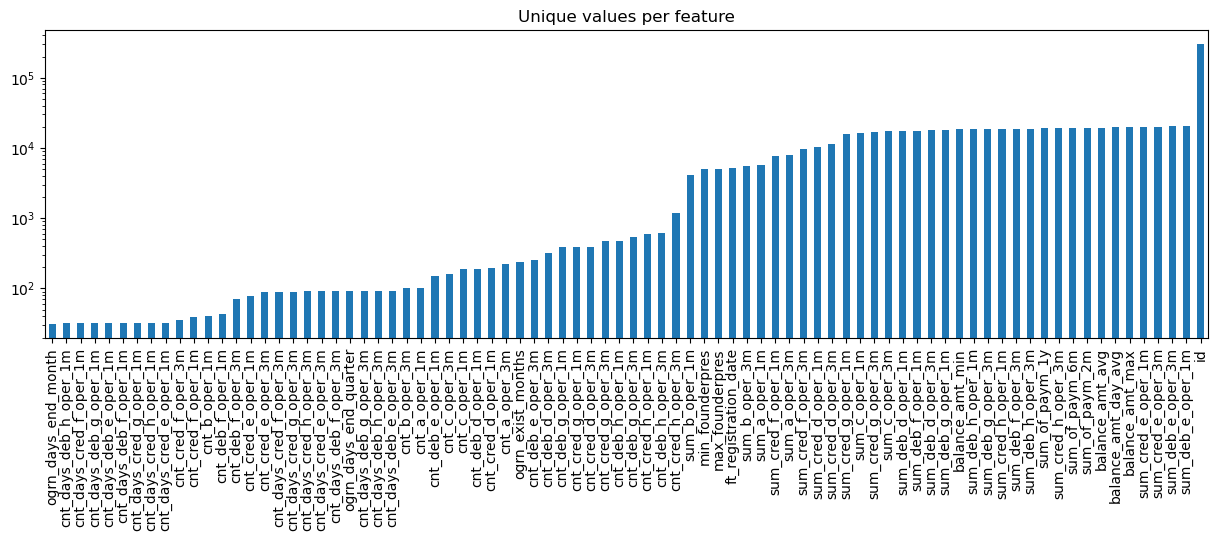

In [12]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()

unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

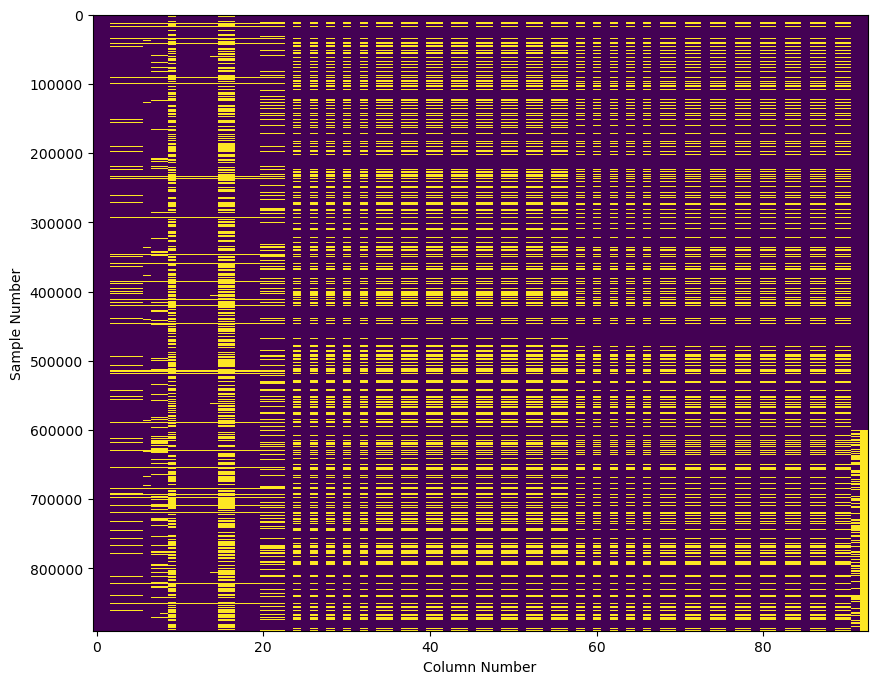

In [13]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")
plt.show()

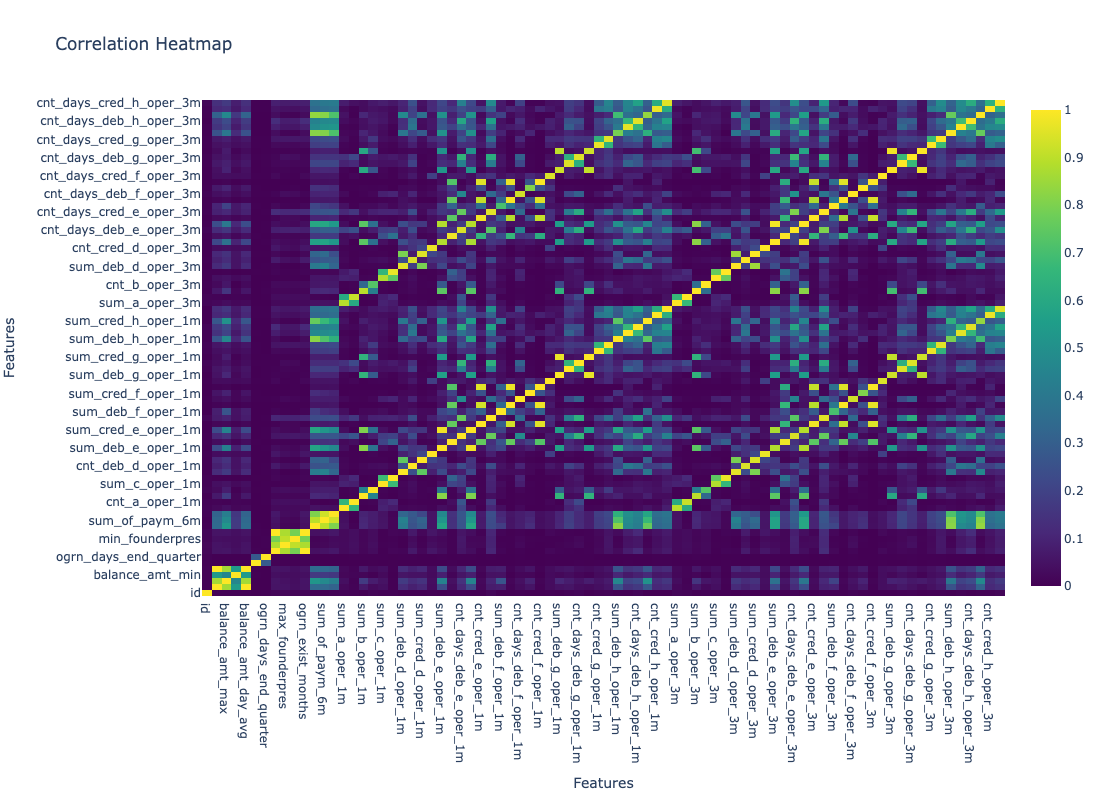

In [15]:
corr = df.select_dtypes(include="number").corr().abs()

fig = go.Figure(data=go.Heatmap(
    z=corr.values,
    x=corr.columns,
    y=corr.columns,
    colorscale='viridis',  
    hoverongaps = False
))

# Настройка макета
fig.update_layout(
    title='Correlation Heatmap',
    xaxis_title='Features',
    yaxis_title='Features',
    width=800, 
    height=800 
)

fig.show()

In [16]:
df.tail()

id     date  balance_amt_avg  balance_amt_max  balance_amt_min  \
890115  299998  month_5              NaN              NaN              NaN   
890116  299998  month_6               -0               -0               -0   
890117  299999  month_4               -0               -0               -0   
890118  299999  month_5               -0               -0               -0   
890119  299999  month_6               -0               -0               -0   

        balance_amt_day_avg    channel_code     city    city_type  \
890115                  NaN             NaN      NaN          NaN   
890116                   -0  channel_code_9  city_25  city_type_0   
890117                   -0  channel_code_9   city_6  city_type_0   
890118                   -0  channel_code_9   city_6  city_type_0   
890119                   -0  channel_code_9   city_6  city_type_0   

           index_city_code  ...  cnt_cred_g_oper_3m  cnt_days_cred_g_oper_3m  \
890115                 NaN  ...                 NaN                      NaN   
890116  index_city_code_30  ...                   1                        0   
890117  index_city_code_34  ...                   1                        0   
890118  index_city_code_34  ...                   1                        0   
890119  index_city_code_34  ...                   1                        0   

       sum_deb_h_oper_3m cnt_deb_h_oper_3m  cnt_days_deb_h_oper_3m  \
890115                -0               NaN                     NaN   
890116                -0                 1                       0   
890117                -0                 1                       1   
890118                -0                 1                       1   
890119                -0                 1                       1   

        sum_cred_h_oper_3m  cnt_cred_h_oper_3m  cnt_days_cred_h_oper_3m  \
890115                  -0                 NaN                      NaN   
890116                  -0                   0                        0   
890117                  -0                   0                        0   
890118                  -0                   0                        0   
890119                  -0                   0                        0   

       start_cluster end_cluster  
890115            {}        None  
890116           NaN        None  
890117           {α}        None  
890118           {α}        None  
890119           NaN        None  

[5 rows x 93 columns]

<Axes: >

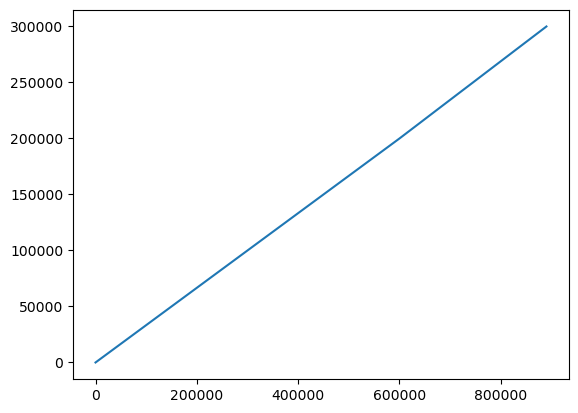

In [17]:
df['id'].plot()

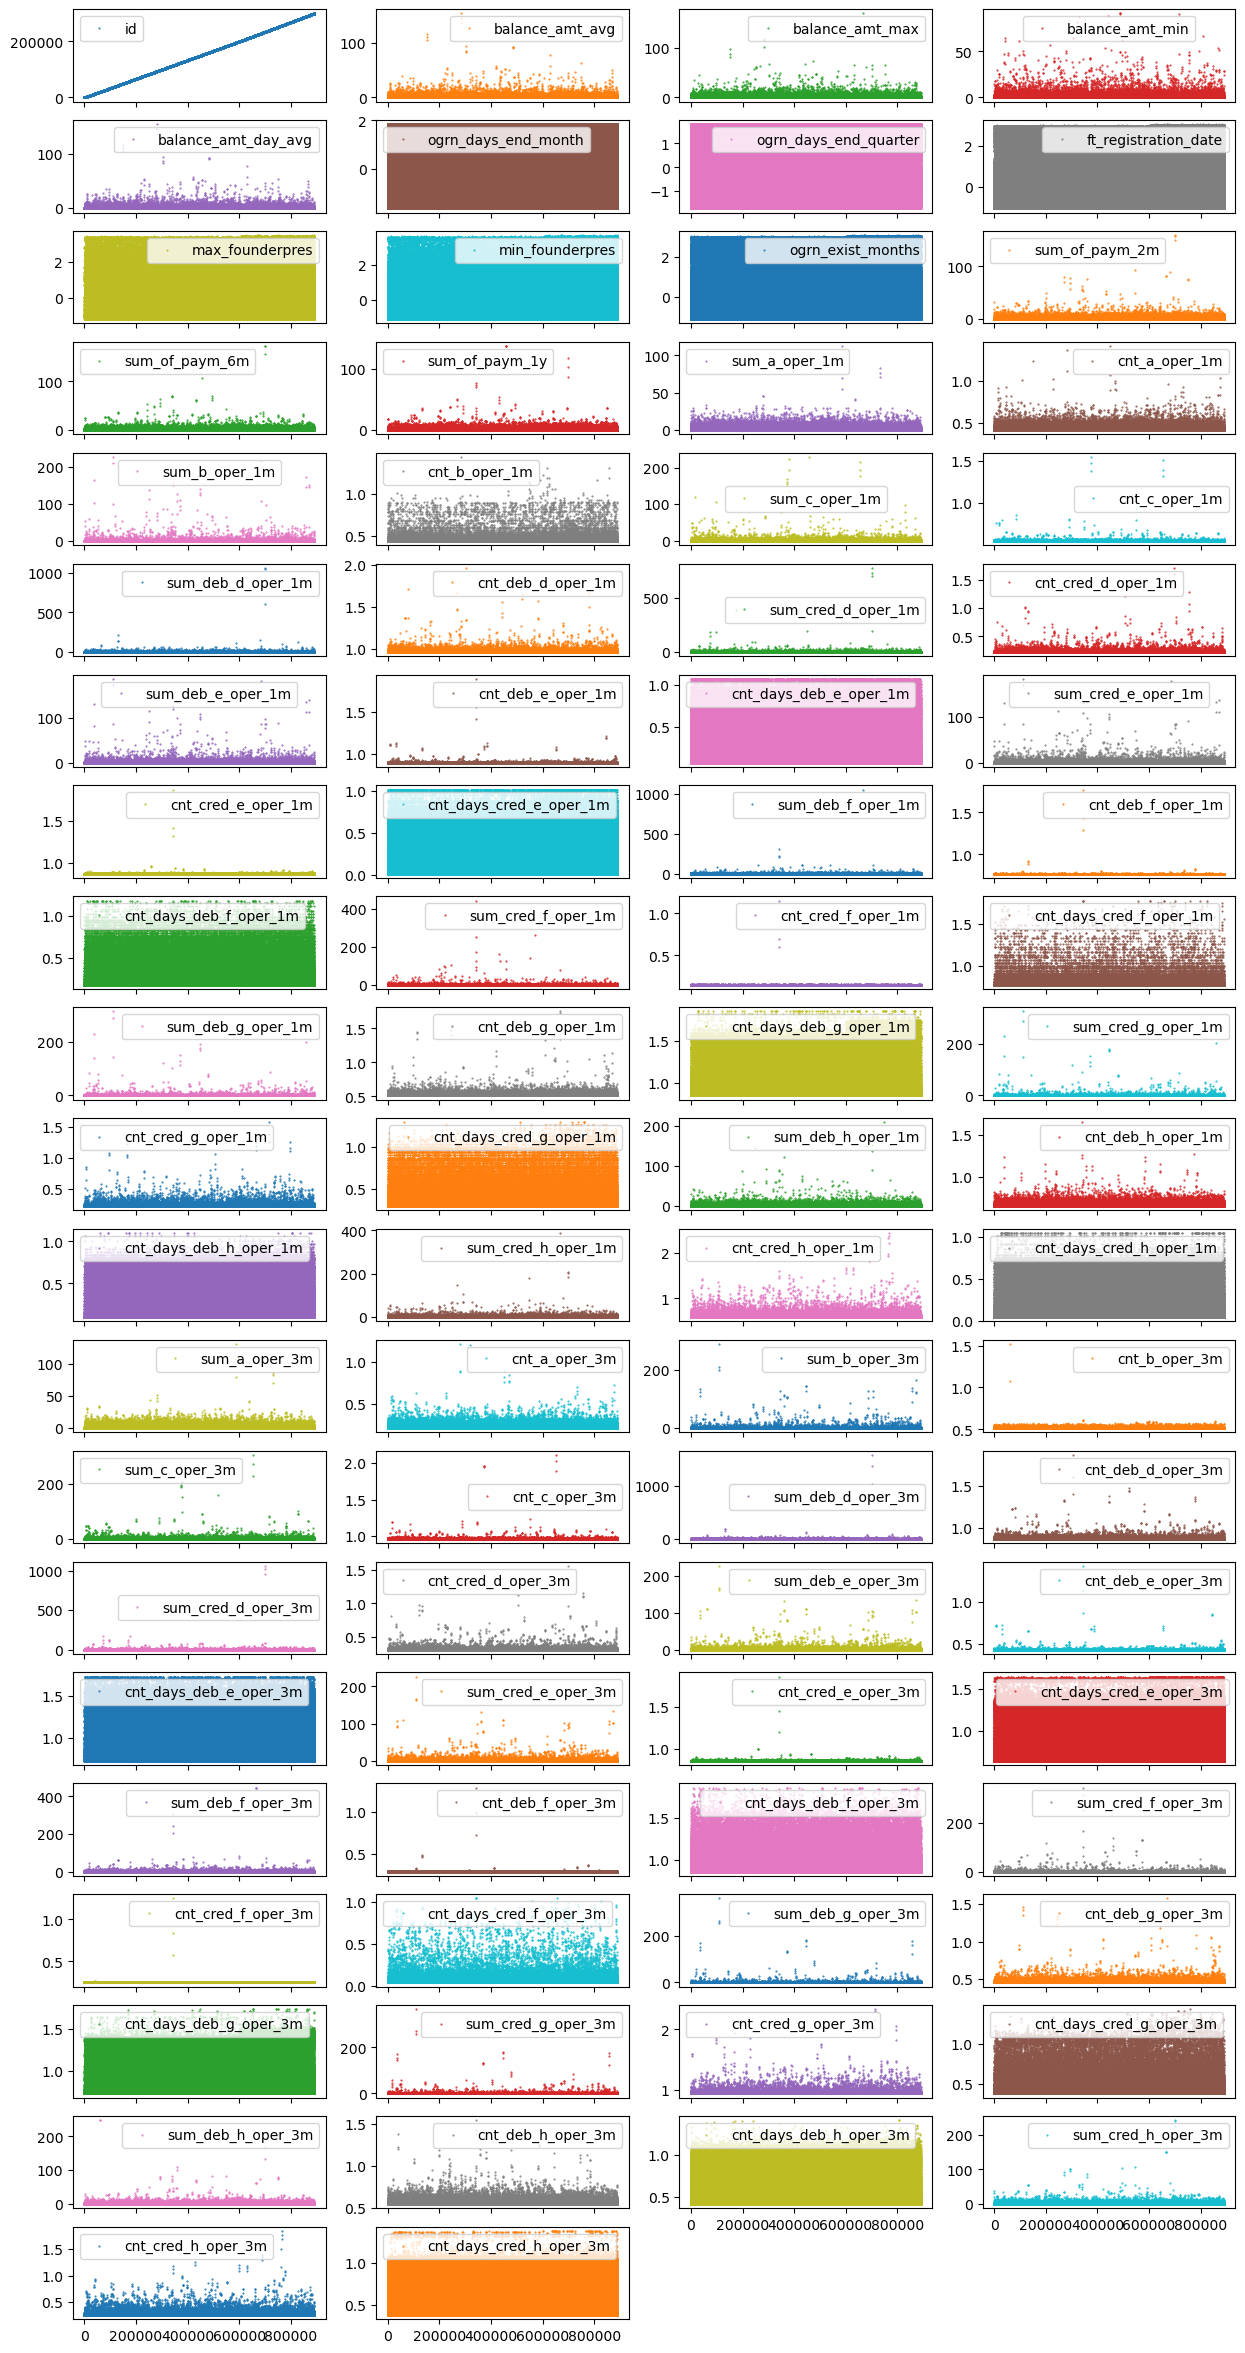

In [18]:
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

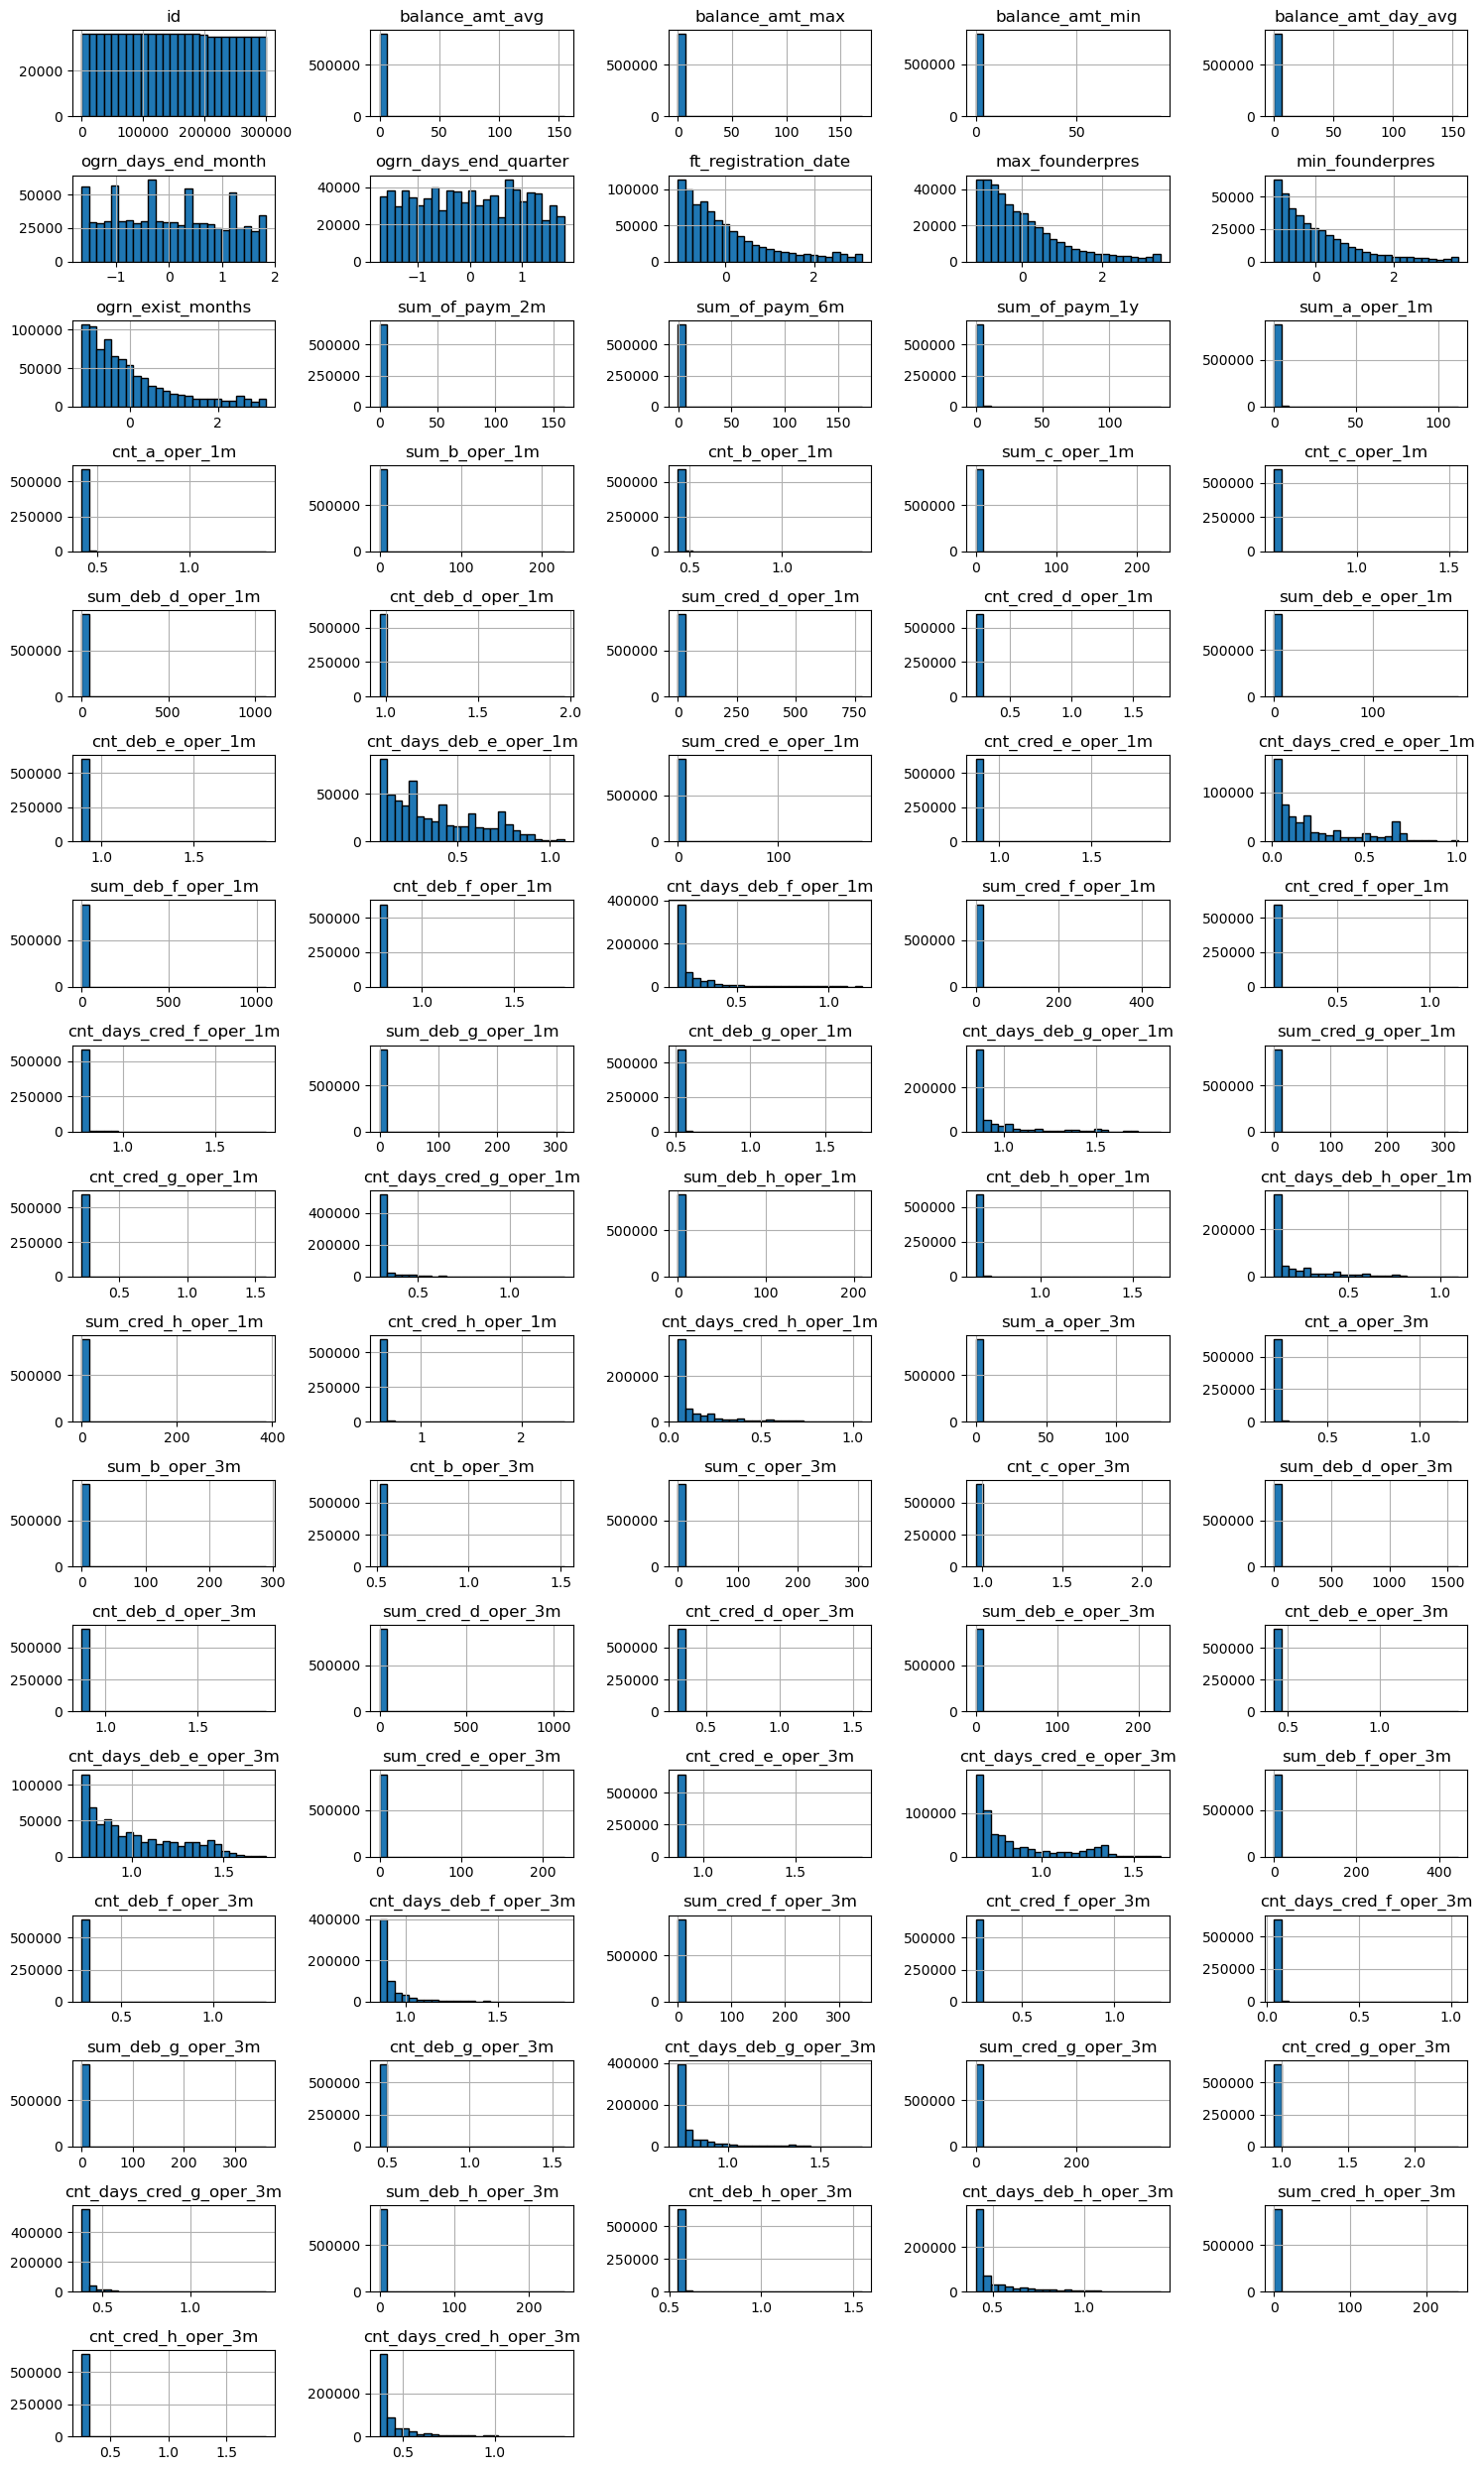

In [74]:
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

In [93]:
sns.pairplot(df, height=1.5, plot_kws={"s": 2, "alpha": 0.2});


KeyboardInterrupt


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x3401c4550> (for post_execute):
Error in callback <function flush_figures at 0x3401f4820> (for post_execute):



KeyboardInterrupt



In [58]:
df.select_dtypes(exclude="number")

date    channel_code     city    city_type     index_city_code  \
0       month_1  channel_code_5  city_23  city_type_0  index_city_code_39   
1       month_2  channel_code_5  city_23  city_type_0  index_city_code_39   
2       month_3  channel_code_5  city_23  city_type_0  index_city_code_39   
3       month_1  channel_code_2  city_14  city_type_0                 NaN   
4       month_2  channel_code_2  city_14  city_type_0                 NaN   
...         ...             ...      ...          ...                 ...   
290115  month_5             NaN      NaN          NaN                 NaN   
290116  month_6  channel_code_9  city_25  city_type_0  index_city_code_30   
290117  month_4  channel_code_9   city_6  city_type_0  index_city_code_34   
290118  month_5  channel_code_9   city_6  city_type_0  index_city_code_34   
290119  month_6  channel_code_9   city_6  city_type_0  index_city_code_34   

           ogrn_month     ogrn_year     okved    segment start_cluster  \
0        ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}   
1        ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}   
2        ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}   
3        ogrn_month_5  ogrn_year_15   okved_5  segment_1       {other}   
4        ogrn_month_5  ogrn_year_15   okved_5  segment_1       {other}   
...               ...           ...       ...        ...           ...   
290115            NaN           NaN       NaN        NaN            {}   
290116   ogrn_month_8  ogrn_year_11  okved_17  segment_2           NaN   
290117  ogrn_month_11  ogrn_year_14  okved_17  segment_3           {α}   
290118  ogrn_month_11  ogrn_year_14  okved_17  segment_3           {α}   
290119  ogrn_month_11  ogrn_year_14  okved_17  segment_3           NaN   

       end_cluster  
0          {other}  
1          {other}  
2          {other}  
3          {other}  
4          {other}  
...            ...  
290115        None  
290116        None  
290117        None  
290118        None  
290119        None  

[890120 rows x 11 columns]

In [15]:
print(df.describe())

          id  balance_amt_avg  balance_amt_max  balance_amt_min  \
count 890120           795060           795060           795060   
mean  148892               -0               -0               -0   
std    86384                1                1                1   
min        0               -0               -0               -0   
25%    74176               -0               -0               -0   
50%   148353               -0               -0               -0   
75%   223309               -0               -0               -0   
max   299999              154              170               91   

       balance_amt_day_avg  ogrn_days_end_month  ogrn_days_end_quarter  \
count               795060               844369                 844369   
mean                    -0                   -0                     -0   
std                      1                    1                      1   
min                     -0                   -2                     -2   
25%                     -0

## Test and Train

In [5]:
train_df.head()

id     date  balance_amt_avg  balance_amt_max  balance_amt_min  \
0   0  month_1                1                1                1   
1   0  month_2                1                1                2   
2   0  month_3                1                1                0   
3   1  month_1               -0               -0               -0   
4   1  month_2               -0               -0               -0   

   balance_amt_day_avg    channel_code     city    city_type  \
0                    1  channel_code_5  city_23  city_type_0   
1                    1  channel_code_5  city_23  city_type_0   
2                    1  channel_code_5  city_23  city_type_0   
3                   -0  channel_code_2  city_14  city_type_0   
4                   -0  channel_code_2  city_14  city_type_0   

      index_city_code  ...  cnt_cred_g_oper_3m  cnt_days_cred_g_oper_3m  \
0  index_city_code_39  ...                   1                        1   
1  index_city_code_39  ...                   1                        0   
2  index_city_code_39  ...                   1                        0   
3                None  ...                   1                        0   
4                None  ...                   1                        0   

  sum_deb_h_oper_3m cnt_deb_h_oper_3m  cnt_days_deb_h_oper_3m  \
0                 1                 1                       1   
1                 1                 1                       1   
2                 1                 1                       1   
3                 0                 1                       1   
4                 0                 1                       1   

   sum_cred_h_oper_3m  cnt_cred_h_oper_3m  cnt_days_cred_h_oper_3m  \
0                   1                   0                        1   
1                   1                   0                        1   
2                   1                   0                        1   
3                  -0                   0                        0   
4                  -0                   0                        0   

  start_cluster end_cluster  
0        {α, γ}     {other}  
1        {α, γ}     {other}  
2        {α, γ}     {other}  
3       {other}     {other}  
4       {other}     {other}  

[5 rows x 93 columns]

In [6]:
test_df.head()

id     date  balance_amt_avg  balance_amt_max  balance_amt_min  \
0  200000  month_4               -0                0               -0   
1  200000  month_5               -0               -0               -0   
2  200000  month_6                0                0               -0   
3  200001  month_4               -0               -0               -0   
4  200001  month_5               -0               -0               -0   

   balance_amt_day_avg     channel_code     city    city_type index_city_code  \
0                   -0  channel_code_12  city_14  city_type_0            None   
1                   -0  channel_code_12  city_14  city_type_0            None   
2                    0  channel_code_12  city_14  city_type_0            None   
3                   -0   channel_code_9  city_76  city_type_0            None   
4                   -0   channel_code_9  city_76  city_type_0            None   

   ...  cnt_cred_g_oper_3m  cnt_days_cred_g_oper_3m sum_deb_h_oper_3m  \
0  ...                   1                        0                -0   
1  ...                   1                        0                -0   
2  ...                   1                        0                -0   
3  ...                 NaN                      NaN                -0   
4  ...                 NaN                      NaN                -0   

  cnt_deb_h_oper_3m  cnt_days_deb_h_oper_3m  sum_cred_h_oper_3m  \
0                 1                       1                   0   
1                 1                       1                   0   
2                 1                       1                   0   
3               NaN                     NaN                  -0   
4               NaN                     NaN                  -0   

   cnt_cred_h_oper_3m  cnt_days_cred_h_oper_3m start_cluster end_cluster  
0                   0                        1           {α}        None  
1                   0                        1           {α}        None  
2                   0                        1          None        None  
3                 NaN                      NaN           {α}        None  
4                 NaN                      NaN           {α}        None  

[5 rows x 93 columns]

In [33]:
train_df = df.iloc[:len(train_df)]
test_df = df.iloc[len(train_df):]

In [38]:
train_df.to_parquet("../data/interim/train_data_lm.pqt")
test_df.to_parquet("../data/interim/test_data_lm.pqt")

## Подготовка к обучению

Создаем выборки для валидации и обучения

In [17]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Обучение модели

В качестве базовой модели возьмем LGBM обучим на всех признаках

`n_jobs=-1` в классификаторе `LGBMClassifier` использует все доступные ядра процессора для параллельного обучения.

`verbosity`=1 для отображения информации о прогрессе обучения. Если вы хотите более детальный вывод, вы можете установить значение verbosity на большее число, например, 2 или 3.



[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.: Это предупреждение указывает на то, что обнаружены категориальные признаки с количеством бинов (групп) больше, чем максимальное число бинов, настроенное в параметре max_bin. Это может произойти, если количество уникальных значений категориального признака слишком велико.

[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.: Это предупреждение указывает на то, что параметры max_bin и max_bin_by_feature могут быть проигнорированы для категориальных признаков с большим числом категорий.

In [19]:
start_time = time.time()
model = LGBMClassifier(verbosity=1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)
end_time = time.time()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.080898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20372
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 90
[LightGBM] [Info] Start training from score -2.542774
[LightGBM] [Info] Start training from score -1.588635
[LightGBM] [Info] Start training from score -3.986612
[LightGBM] [Info] Start training from score -2.860182
[LightGBM] [Info] Start training from score -4.994823
[LightGBM] [Info] Start training from score -5.896912
[LightGBM] [Info] Start training from score -6.278036
[LightGBM] [Info] Start training from score -7.457524
[LightGBM] [Info] Start training from score -4

In [20]:
training_time = end_time - start_time
print("Время обучения модели:", training_time, "секунд")

Время обучения модели: 310.7779951095581 секунд


### Save model

In [ ]:
# dump model with pickle
with open("/models/baseline_model.pkl", "wb") as fout:
    pickle.dump(gbm, fout)

### Load model

In [ ]:
# load model with pickle to predict
with open("/models/baseline_model.pkl", "rb") as fin:
    model = pickle.load(fin)

Зададим функцию для взвешенной метрики roc auc.

Эта функция полезна при оценке качества мультиклассовых моделей классификации с учетом дисбаланса классов, позволяя учитывать важность каждого класса при вычислении ROC AUC.

In [21]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [22]:
cluster_weights = pd.read_excel("/content/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

FileNotFoundError: [Errno 2] No such file or directory: '/content/cluster_weights.xlsx'

Проверка работы модели

In [ ]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(120000, 17)

In [ ]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.7435520713146397

## Прогноз на тестовой выборке

In [ ]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

date   month_4 month_5 month_6
id                            
200000     {α}     {α}     NaN
200001     {α}     {α}     NaN
200002     {α}     {α}     NaN

Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>
В качестве базового подхода заполним все стартовые кластеры, самым популярным кластером.

In [ ]:
test_df["start_cluster"] = train_df["start_cluster"].mode()[0]
test_df["start_cluster"] = test_df["start_cluster"].astype("category")

In [ ]:
sample_submission_df = pd.read_csv("sample_submission.csv")

In [ ]:
sample_submission_df.shape

(100000, 18)

In [ ]:
sample_submission_df.head()

id  {other}    {}  {α, β}  {α, γ}  {α, δ}  {α, ε, η}  {α, ε, θ}  \
0  200000      0.2  0.05    0.05    0.05    0.05       0.05       0.05   
1  200001      0.2  0.05    0.05    0.05    0.05       0.05       0.05   
2  200002      0.2  0.05    0.05    0.05    0.05       0.05       0.05   
3  200003      0.2  0.05    0.05    0.05    0.05       0.05       0.05   
4  200004      0.2  0.05    0.05    0.05    0.05       0.05       0.05   

   {α, ε, ψ}  {α, ε}  {α, η}  {α, θ}  {α, λ}  {α, μ}  {α, π}  {α, ψ}   {α}  \
0       0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  0.05   
1       0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  0.05   
2       0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  0.05   
3       0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  0.05   
4       0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  0.05   

    {λ}  
0  0.05  
1  0.05  
2  0.05  
3  0.05  
4  0.05

Для тестовой выборки будем использовать только последний месяц

In [ ]:
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

In [ ]:
test_pred_proba = model.predict_proba(last_m_test_df)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [ ]:
test_pred_proba_df.shape

(100000, 17)

In [ ]:
test_pred_proba_df.head(2)

{other}        {}    {α, β}    {α, γ}    {α, δ}  {α, ε, η}     {α, ε, θ}  \
0  0.018570  0.438989  0.001094  0.003762  0.000294   0.000116  1.297136e-07   
1  0.195437  0.017019  0.043320  0.000162  0.005102   0.000003  6.688079e-05   

   {α, ε, ψ}    {α, ε}    {α, η}    {α, θ}        {α, λ}    {α, μ}  {α, π}  \
0        0.0  0.000829  0.013894  0.001293  5.290471e-11  0.001651     0.0   
1        0.0  0.017252  0.005322  0.015416  7.473112e-08  0.000532     0.0   

     {α, ψ}       {α}  {λ}  
0  0.000015  0.519494  0.0  
1  0.000225  0.700143  0.0

In [ ]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("baseline_submission.csv", index=False)